In [85]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import torch.nn.functional as F
import cv2
import torch.utils.data as Data
if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 100
batch_size = 1000
learning_rate = 1e-3

img_transform = transforms.Compose([
transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
data1 = cv2.imread('pos1_28x28.png')
data2= cv2.imread('pos2_28x28.png')

result = np.repeat(data1[np.newaxis,...], 60000, axis=0)
print(result.shape)
y0 = result.astype('float32')




result1 = np.repeat(data2[np.newaxis,...], 60000, axis=0)
y1 = result1.astype('float32')


y0 = np.transpose(y0, (0, 3, 2, 1))# This to make channels first for CNN
y1 = np.transpose(y1, (0, 3, 2, 1)) 


print(y0.shape)

x = torch.from_numpy(y0)
y = torch.from_numpy(y1)



torch_dataset = Data.TensorDataset(x,y)


loader = Data.DataLoader(

    dataset=torch_dataset,

    batch_size=250,

    shuffle=True,

    num_workers=0,

)

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        #x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        #x = self.pool(x)  # compressed representation
        

        return x

class auto_decoder(nn.Module):
    def __init__(self):
        super(auto_decoder,self).__init__()
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 3,padding=1)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 3,padding=1)
        
    def forward(self, x):
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x
    

model = autoencoder()


def h_score(fx, gy):
 
    fx = fx - fx.mean(0)

    gy = gy - gy.mean(0)

    Nsamples = fx.size(0)

    covf = torch.matmul((fx.permute(0, 1,3,2)), fx) / Nsamples

    covg = torch.matmul((gy.permute(0, 1,3,2)), (gy)) / Nsamples

    h = -2 * torch.mean((fx * gy).sum(1)) + (covf * covg).sum()

    return h

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

model_1 = auto_decoder()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=learning_rate,
                             weight_decay=1e-5)


for epoch in range(num_epochs):
    for x,y in loader:

        # ===================forward=====================
        #loss = criterion(output1, img)
        loss = h_score(model(x),model(y))
        # ===================backward====================
        optimizer.zero_grad()
        #optimizer_1.zero_grad()
        loss.backward()
        optimizer.step()
        #optimizer_1.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.item()))


torch.save(model.state_dict(), './conv_autoencoder.pth')

(60000, 28, 28, 3)
(60000, 3, 28, 28)
epoch [1/100], loss:0.0000
epoch [2/100], loss:0.0000
epoch [3/100], loss:0.0000
epoch [4/100], loss:0.0000
epoch [5/100], loss:0.0000
epoch [6/100], loss:0.0000
epoch [7/100], loss:0.0000
epoch [8/100], loss:0.0000
epoch [9/100], loss:0.0000
epoch [10/100], loss:0.0000
epoch [11/100], loss:0.0000
epoch [12/100], loss:0.0000
epoch [13/100], loss:0.0000
epoch [14/100], loss:0.0000
epoch [15/100], loss:0.0000
epoch [16/100], loss:0.0000
epoch [17/100], loss:0.0000
epoch [18/100], loss:0.0000
epoch [19/100], loss:0.0000
epoch [20/100], loss:0.0000
epoch [21/100], loss:0.0000
epoch [22/100], loss:0.0000
epoch [23/100], loss:0.0000
epoch [24/100], loss:0.0000
epoch [25/100], loss:0.0000
epoch [26/100], loss:0.0000
epoch [27/100], loss:0.0000
epoch [28/100], loss:0.0000
epoch [29/100], loss:0.0000
epoch [30/100], loss:0.0000
epoch [31/100], loss:0.0000
epoch [32/100], loss:0.0000
epoch [33/100], loss:0.0000
epoch [34/100], loss:0.0000
epoch [35/100], los

In [86]:
z1 = model.conv1.weight
z2 = model.conv2.weight
z1 = torch.nn.Parameter(z1)
z2 = torch.nn.Parameter(z2)



model_1.t_conv1.weight = torch.nn.Parameter(z2.permute(0,1,3,2))
model_1.t_conv2.weight = torch.nn.Parameter(z1.permute(0,1,3,2))
z3 = model_1.t_conv1.weight
z4 = model_1.t_conv2.weight

print(np.shape(z1),np.shape(z2),np.shape(z3),np.shape(z4))

torch.Size([16, 3, 3, 3]) torch.Size([4, 16, 3, 3]) torch.Size([4, 16, 3, 3]) torch.Size([16, 3, 3, 3])


torch.Size([1, 4, 28, 28])


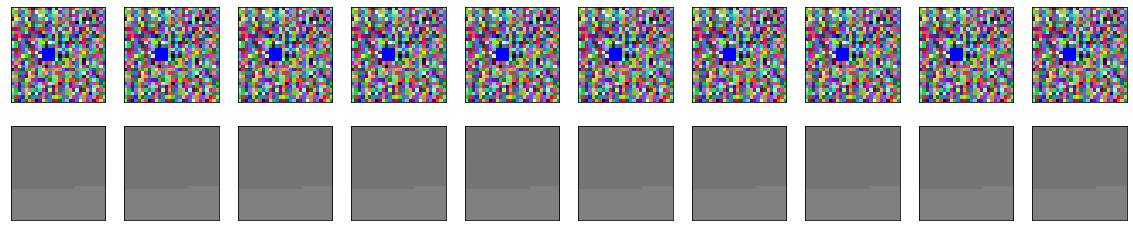

In [89]:
import matplotlib.pyplot as plt
# obtain one batch of test images
dataiter = iter(dataloader)
images, labels = dataiter.next()
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    k = model(x[i].reshape(1,3,28,28))
    z = (model_1(k)).reshape(28, 28,3)
    plt.imshow(z.detach().numpy())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
print(np.shape(k))
plt.show()